In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
import re
import nltk
import string
from nltk.stem.porter import PorterStemmer
from keras.preprocessing.text import one_hot
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten ,Dropout
from keras.layers import Embedding

In [2]:
df = pd.read_csv("Hotel_Reviews.csv")
# append the positive and negative text reviews
df["review"] = df["Negative_Review"] + df["Positive_Review"]
# create the label
df["bad_review"] = df["Reviewer_Score"].apply(lambda x: 0 if x>5 else 1)
# select only relevant columns
df = df[["review", "bad_review"]]

In [3]:
df.head()

,review,bad_review
0,I am so angry that i made this post available...,1
1,No Negative No real complaints the hotel was g...,0
2,Rooms are nice but for elderly a bit difficul...,0
3,My room was dirty and I was afraid to walk ba...,1
4,You When I booked with your company on line y...,0


In [4]:
Counter(df['bad_review']) #checking counter of 0 and 1

Counter({1: 30703, 0: 485035})

<AxesSubplot:xlabel='bad_review', ylabel='count'>

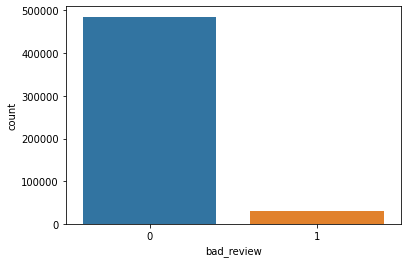

In [5]:
sns.countplot(x='bad_review',data=df) #plotting bad and good reviews count

In [6]:
print(df['review'].apply(lambda x: len(x.split(' '))).sum()) #checking total words

18541403


In [7]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
spec_chara = re.compile('[/(){}\[\]\|@,;]') # REMOVING SPECIAL CHARACTERS 
ext_sym = re.compile('[^0-9a-z #+_]') #EXTRA SYMBOLS
st = set(stopwords.words('english')) # USING STOPWORD FUNCTION

[nltk_data] Downloading package punkt to C:\Users\Laptop
[nltk_data]     Outlet\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Laptop
[nltk_data]     Outlet\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Laptop Outlet\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to C:\Users\Laptop
[nltk_data]     Outlet\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [8]:
def clean(words): #Data cleaning function
    words = words.lower() #Lower words in data
    words = spec_chara.sub(' ', words) #REMOVING SPECIAL CHARACTERS  in data
    words = ext_sym.sub('', words)#EXTRA SYMBOLS removing
    words = ' '.join(word for word in words.split() if word not in st) #using stopwords
    return words


In [9]:
df['clean'] = df['review'].apply(clean) #cleaning text
df = df.drop(['review'], axis =1) #dropping review column

In [10]:
df.head()

,bad_review,clean
0,1,angry made post available via possible sites u...
1,0,negative real complaints hotel great great loc...
2,0,rooms nice elderly bit difficult rooms two sto...
3,1,room dirty afraid walk barefoot floor looked c...
4,0,booked company line showed pictures room thoug...


In [11]:
voc_size=10000 #giving voc size
embedded_sentences=[one_hot(words,voc_size)for words in df.clean]  # embedding sent and one hot encoding them

In [12]:
print(embedded_sentences[5])

[5596, 2568, 7276, 9196, 7669, 2568, 2384, 5328, 8334, 1490, 7826, 4335, 9133, 5753, 1778, 9133, 240, 9170, 2568, 5123, 1672, 6546]


In [13]:
corpus = df["clean"]

## create list of lists of unigrams
lst_corpus = []
for string in corpus:
    lst_words = string.split()
    lst_grams = [" ".join(lst_words[i:i+1]) 
                 for i in range(0, len(lst_words), 1)]
    lst_corpus.append(lst_grams)

In [14]:
from nltk.tokenize import word_tokenize

word_count = lambda sentence: len(word_tokenize(sentence)) #total words
longest_sentence = max(corpus, key=word_count) #long sent 
length_long_sentence = len(word_tokenize(longest_sentence))

In [15]:
length_long_sentence

381

In [16]:
embedded_docs=pad_sequences(embedded_sentences,padding='pre',maxlen=length_long_sentence) #prepadding making data for keras model
print(embedded_docs)

[[   0    0    0 ... 3209 2568 8265]
 [   0    0    0 ... 6535 7486 8493]
 [   0    0    0 ...  466 2125 6535]
 ...
 [   0    0    0 ... 2340   27 7838]
 [   0    0    0 ... 2014 6071 3324]
 [   0    0    0 ... 7722 1028 2173]]


In [17]:
X = embedded_docs  #define x and y
y = df['bad_review']

In [18]:
from imblearn.over_sampling import SMOTE

oversample = SMOTE() #oversampling as data is imbalance
X, y = oversample.fit_resample(X, y) #fit and resampling oversampling
counter = Counter(y) #seeing count after resample
print(counter)

Counter({1: 485035, 0: 485035})


In [19]:
from sklearn.model_selection import train_test_split #splitting train test
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3, random_state=42)

# Model

In [20]:
model = Sequential() #making keras deep learning model structure
model.add(Embedding(voc_size, 20, input_length=length_long_sentence))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [21]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc']) #compiling model
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 381, 20)           200000    
                                                                 
 flatten (Flatten)           (None, 7620)              0         
                                                                 
 dropout (Dropout)           (None, 7620)              0         
                                                                 
 dense (Dense)               (None, 1)                 7621      
                                                                 
Total params: 207,621
Trainable params: 207,621
Non-trainable params: 0
_________________________________________________________________
None


In [22]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint_path = 'my_best_model.hdf5' #saving best weights 

checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='val_acc',verbose=1, save_best_only=True,mode='max') #saving best model

earlystopping = EarlyStopping(monitor='val_acc', patience=2, restore_best_weights=True)  #defining patience if val_acc dont increase consisitenly in two epochs model stops

callbacks = [checkpoint, earlystopping]

In [23]:
history = model.fit(X_train, y_train, batch_size =1000, epochs = 5, verbose=1, shuffle=False, validation_data=(X_test, y_test), callbacks=callbacks)# fitting model

Epoch 1/5
679/680 [============================>.] - ETA: 0s - loss: 0.2080 - acc: 0.9198
Epoch 1: val_acc improved from -inf to 0.95674, saving model to my_best_model.hdf5
680/680 [==============================] - 107s 157ms/step - loss: 0.2080 - acc: 0.9198 - val_loss: 0.1245 - val_acc: 0.9567
Epoch 2/5
679/680 [============================>.] - ETA: 0s - loss: 0.1191 - acc: 0.9566
Epoch 2: val_acc improved from 0.95674 to 0.95922, saving model to my_best_model.hdf5
680/680 [==============================] - 106s 157ms/step - loss: 0.1191 - acc: 0.9566 - val_loss: 0.1129 - val_acc: 0.9592
Epoch 3/5
679/680 [============================>.] - ETA: 0s - loss: 0.1114 - acc: 0.9593
Epoch 3: val_acc improved from 0.95922 to 0.96014, saving model to my_best_model.hdf5
680/680 [==============================] - 107s 158ms/step - loss: 0.1114 - acc: 0.9593 - val_loss: 0.1093 - val_acc: 0.9601
Epoch 4/5
679/680 [============================>.] - ETA: 0s - loss: 0.1073 - acc: 0.9609
Epoch 4: v

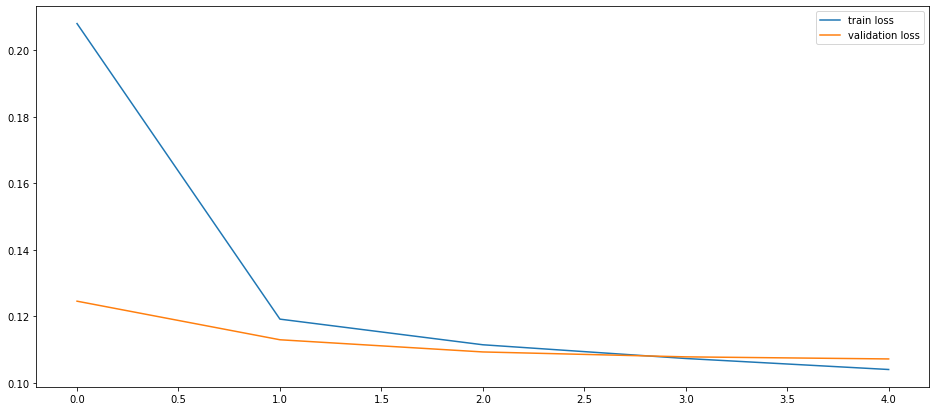

In [24]:
plt.figure(figsize=(16,7)) #plotting loss plot of keras model
plt.plot(history.history["loss"], label= "train loss")
plt.plot(history.history["val_loss"], label= "validation loss")
plt.legend()

In [25]:
y_pred = np.where(model.predict(X_test)>.5,1,0) #converting prediction into 1 and 0

9095/9095 [==============================] - 15s 2ms/step


In [26]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score #making classification report od our prediction and real labels
print(classification_report(y_pred, y_test)) 
print(confusion_matrix(y_pred, y_test))
print(accuracy_score(y_pred, y_test))
print(precision_score(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.98      0.95      0.96    150084
           1       0.95      0.98      0.96    140937

    accuracy                           0.96    291021
   macro avg       0.96      0.96      0.96    291021
weighted avg       0.96      0.96      0.96    291021

[[142087   7997]
 [  3488 137449]]
0.9605354940021511
0.9450173947719428


In [27]:
cfm = confusion_matrix(y_test,y_pred) #making confusion_matrix od our presiction and real labels
cfm

array([[142087,   3488],
       [  7997, 137449]], dtype=int64)

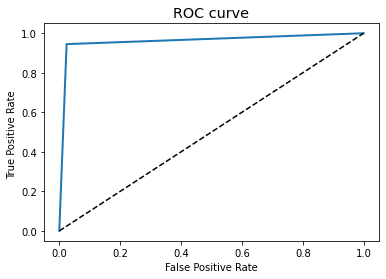

In [28]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0,1], [0,1], 'k--' )
plt.rcParams['font.size'] = 12
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate ')
plt.show()

In [29]:
from sklearn.metrics import roc_auc_score
ROC_AUC = roc_auc_score(y_test, y_pred)
print('ROC AUC : {:.4f}'.format(ROC_AUC))

ROC AUC : 0.9605


# Making prediction Function
Now we will test or model on raw reviews and see its working

In [43]:
from numpy.random import seed
seed(42)
from keras.backend import manual_variable_initialization 
manual_variable_initialization(True)
import tensorflow
model = tensorflow.keras.models.load_model('my_best_model.hdf5')

In [44]:
GOOD_WORDS = [
    'clean' ,'nice', 'wonderful', 'good', 'astonishing', 'brilliant', 'like', 'love', 'loved', 'perfect', 'excellent', 'comfortable', 'very nice', 
'very clean', 'tidy', 'very good', 'better', 'best', 'prefer', 'admire', 'adore', 'delight', 'enjoy', 'fancy', 'super', 'superb', 'pleasant', 
'love', 'relish', 'wow', 'cool', 'amazing', 'awesome', 'beautiful', 'lovely', 'sweet', 'cute', 'stunning', 'friendly', 'gorgeous', 'spacious',
'great', 'new', 'quality', 'special', 'helpful', 'peaceful', 'pretty', 'fabulous', 'tasteful', 'tasty', 'interesting', 'comfy', 'fantastic', 'delicious', 
'huge', 'potential', 'spacious', 'fashionable', 'trendy', 'reasonable', 'impress', 'impressive', 'delightful', 'stylish', 'polite', 'luxury',
'convenient', 'professional', 'modern'
    
] #hard encoding good reviews words list

In [45]:
ISSUES_CATEGORIES = {
    'room': ['room','window', 'table' ,'mirror','door' ,'lock','key','bed','wifi', 'pillow', 'bed sheet', 'dressing table' ],
    'food':['food', 'dish' , 'menu', 'recipe' ,'bread' ,'cooking','drink','fare','meal','meat','snack' ,'fish', 'seafood','foodstuff', 'vegetables', 'spicy', 'fruits', 'liquor', 'tea', 'coffee'],
    'kitchen' : ['kitchen','fridge','mixer','knife','cutlery','fork', 'vegetables', 'fruits', 'spices', 'tea maker', 'coffee maker'],
    'electrical' : ['electrical' , 'light' , 'lamp', 'fan', 'A/C', 'air conditioner', 'electronic' ,'electricity', 'TV', 'plug','socket','power','powerline','power cord','switch', 'switches', 'breaker'],
    'washroom': ['washroom','bath','bathroom','water','toilet','restroom','bathtub','shower','hot water'],
    'pool' : ['pool','swimming','water','swim','swimpool', 'swimming pool', 'çhlorine'],
    'other' : ['telephone', 'alarm', 'sensor','service', 'price', 'other','others','misc','miscs','miscellaneous','miscellaneouss','music', 'band', 'musical band', 'parking' , 'cinema', 'environment'],
    'bar' : ['drinking' , 'drink' , 'wine' , 'bar'],
    'night club': ['night club', 'dance', 'dancing floor', 'DJ', 'music'] 
}

#NEGATION_ATTRUIBUITES such as 'not' 'un' 'dis' ...
NEGATION_ATTRUIBUITES = [
    'not','un','dis', 'im', 'in'
]

#NEGATION_WORDS such as 'no' 'don\'t' 'don\'t' ...
NEGATION_WORDS = [
    'no','don\'t', 'not happy' , 'issues' ,'issue' , 'doesnt' , 'dont' , 'not' , 'but' ,'isnt', 'arent','wasnt','werent',"doesn't", "dont like", "bad"
]



In [46]:
import spacy 
# Text Preprocessing Pkg
from spacy.lang.en.stop_words import STOP_WORDS
from string import punctuation
# Import Heapq 
from heapq import nlargest , nsmallest
# Build a List of Stopwords
stopwords = list(STOP_WORDS)
#load the english model
nlp = spacy.load('en_core_web_sm')

def clean_text(text):
    text = text.lower() #Lower words in data
    text = spec_chara.sub(' ', text) #REMOVING SPECIAL CHARACTERS  in data
    text = ext_sym.sub('', text)#EXTRA SYMBOLS removing
    text = ' '.join(text for text in text.split() if text not in st) #using stopwords
    return text

def flatten_list(list_of_lists):
    return [item for sublist in list_of_lists for item in sublist]


#this function take issue phrase and category keyword and return the score
def get_score_for_issue_by_category(issue , category_keywords):
    score = 0
    for keyword in list(set(category_keywords)):
        if keyword in issue:
            score += 1
    return score


#this function loops throw category issues and get the most scored catgory for each issue
def get_most_scored_category(issue):
    category_scores = {}
    for category in ISSUES_CATEGORIES:
        score = get_score_for_issue_by_category(issue, ISSUES_CATEGORIES[category])
        category_scores[category] = score if score > 0 else 0
    # return the category with the highest score using max function
    return max(category_scores, key=category_scores.get)


#loop throw the list of issues and for each issue loop throw ISSUES
def identity_issues(list_of_issues):
    issues = {
        category : [] for category in ISSUES_CATEGORIES
    }
    #loop throw the list of issues and get the most scored category for each issue
    for issue in list_of_issues:
        most_scored_category = get_most_scored_category(issue)
        issues[most_scored_category].append(issue)

    return issues


# text preprocessing function
def text_summarizer(raw_docx):
    raw_text = raw_docx
    docx = nlp(raw_text)
    stopwords = list(STOP_WORDS)
    # Build Word Frequency
    # word.text is tokenization in spacy
    word_frequencies = {}  
    for word in docx:  
        if word.text not in stopwords:
            if word.text not in word_frequencies.keys():
                word_frequencies[word.text] = 1
            else:
                word_frequencies[word.text] += 1

    maximum_frequncy = max(word_frequencies.values())

    for word in word_frequencies.keys():  
        word_frequencies[word] = (word_frequencies[word]/maximum_frequncy)
    # Sentence Tokens
    sentence_list = [ sentence for sentence in docx.sents ]

    # Calculate Sentence Score and Ranking
    sentence_scores = {}  
    for sent in sentence_list:  
        for word in sent:
            if word.text.lower() in word_frequencies.keys():
                if len(sent.text.split(' ')) < 30:
                    if sent not in sentence_scores.keys():
                        sentence_scores[sent] = word_frequencies[word.text.lower()]
                    else:
                        sentence_scores[sent] += word_frequencies[word.text.lower()]

    # Find N Largest
    summary_sentences = nlargest(10, sentence_scores, key=sentence_scores.get)
    final_sentences = [ w.text for w in summary_sentences ]
    summary = ' '.join(final_sentences)
    
    #clear summary to have one space between sentences and words and \n
    summary = summary.replace('\n', ' ')
    summary = summary.replace('\r', ' ')
    summary_list = summary.split(' ')
    summary_list = [x for x in summary_list if x != '' and x != ' ']
    summary = ' '.join(summary_list)

    #split list of sentences to list of words with . or , or ? or ! or : or ;
    punctuation = ['.' , ',' , '?' , '!' , ':' , ';']
    list_of_issues = []
    for char in summary:
        if char in punctuation:
            list_of_issues.append(summary[:summary.index(char)])
            summary = summary[summary.index(char)+1:]

    list_of_issues = [clean_text(x) for x in list_of_issues if x != '' and len(x.split(' ')) > 2]

    obj = {
        "length": len(summary),
        "list_of_issues": list_of_issues,
        "list_of_issues_for_each_category": identity_issues(list_of_issues)
    }
    return obj


In [47]:
def predict(data):
    if any(word in data for word in NEGATION_WORDS): #encoding list for bad reviews
        print('Bad Review')
        text = text_summarizer(data)
        print(text) 
    elif any(word in data for word in GOOD_WORDS):#encoding list for good reviews
        print([data])
        print('Good Review')
    else:
        clean(data) #cleaning data
        voc_size=10000 #define vocab size
        embedded_sentences=[one_hot(data,voc_size)] #onehot encoding all words giving different numbers
        embedded_docs=pad_sequences(embedded_sentences,padding='pre',maxlen=381) #prepadding
        probability = model.predict(embedded_docs) #predicting model
        #print(probability)
        if probability >= 0.5:
            text = text_summarizer(data)
            print(text)
            print('Bad Review')
        else:
            print([data])
            print('Good Review')

In [48]:
predict('I love this place. this place is wonderful')

['I love this place. this place is wonderful']
Good Review


In [49]:
predict('Very Bad hotel never staying again here.')

1/1 [==============================] - 0s 120ms/step
{'length': 0, 'list_of_issues': ['bad hotel never staying'], 'list_of_issues_for_each_category': {'room': ['bad hotel never staying'], 'food': [], 'kitchen': [], 'electrical': [], 'washroom': [], 'pool': [], 'other': [], 'bar': [], 'night club': []}}
Bad Review


In [51]:
predict('i dont love this hotel')

Bad Review
{'length': 22, 'list_of_issues': [], 'list_of_issues_for_each_category': {'room': [], 'food': [], 'kitchen': [], 'electrical': [], 'washroom': [], 'pool': [], 'other': [], 'bar': [], 'night club': []}}


In [52]:
predict('fan doesnt work')

Bad Review
{'length': 15, 'list_of_issues': [], 'list_of_issues_for_each_category': {'room': [], 'food': [], 'kitchen': [], 'electrical': [], 'washroom': [], 'pool': [], 'other': [], 'bar': [], 'night club': []}}


In [53]:
predict('The environment of the hotel was really cool. But when talking about the hotel in our room the table lamp was broken. The room is quite smelly as well and room-boys service was terrible. And therewas only cold water in bathroom. There was also no enough space in luggage to keep our belongings. The price is a bit high when compared to other hotels in the area. But the Swimming pool is pretty large and I really like that. Huge parking space is also available which is really good. There were two issues which surprised me that could work to make the hotel perfect. One is that WIFI connection was weak sometimes. And the other is the food as its not tasty bad food. I don’t expect to come back again.')

Bad Review
{'length': 0, 'list_of_issues': ['room quite smelly well roomboys service terrible', 'talking hotel room table lamp broken', 'two issues surprised could work make hotel perfect', 'price bit high compared hotels area', 'food tasty bad food', 'environment hotel really cool', 'huge parking space also available really good', 'therewas cold water bathroom', 'also enough space luggage keep belongings', 'swimming pool pretty large really like'], 'list_of_issues_for_each_category': {'room': ['room quite smelly well roomboys service terrible', 'talking hotel room table lamp broken', 'two issues surprised could work make hotel perfect', 'also enough space luggage keep belongings'], 'food': ['food tasty bad food'], 'kitchen': [], 'electrical': [], 'washroom': ['therewas cold water bathroom'], 'pool': ['swimming pool pretty large really like'], 'other': ['price bit high compared hotels area', 'environment hotel really cool', 'huge parking space also available really good'], 'bar': [], '

In [54]:
predict('This place is not good room are small. I dont like this place. night club is not good')

Bad Review
{'length': 23, 'list_of_issues': ['place good room small', 'dont like place'], 'list_of_issues_for_each_category': {'room': ['place good room small', 'dont like place'], 'food': [], 'kitchen': [], 'electrical': [], 'washroom': [], 'pool': [], 'other': [], 'bar': [], 'night club': []}}
